In [1]:
# Para visualización en notebook
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (8,6)
mpl.rcParams['font.size'] = 22
import seaborn as sns

# Números y Datos
import numpy as np
import pandas as pd

import networkx as nx

from glob import glob
from pathlib import Path

In [2]:
filenames = glob('DataSujetos/*.csv')
df = pd.read_csv(filenames[0], header=-1)
n = df.shape[0]
df -= np.diag(np.ones(n))

print("Nro de archivos = " + str(len(filenames)))
subjects = set()
sleepStages = set()
for filename in filenames:
        subjects.add(filename[filename.index('_') + 1:-4])
        sleepStages.add(filename[filename.index('/') + 1: filename.index('_')])
print("Nro de sujetos = " + str(len(subjects)))
print("Nro de estadios = " + str(len(sleepStages)))

sleepStagesOrdered = ("W", "N1", "N2", "N3")

print("sleepStages = " + str(sleepStages))
print("sleepStagesOrdered = " + str(sleepStagesOrdered))

Nro de archivos = 72
Nro de sujetos = 18
Nro de estadios = 4
sleepStages = {'W', 'N3', 'N1', 'N2'}
sleepStagesOrdered = ('W', 'N1', 'N2', 'N3')


In [3]:
#Toma un archivo csv con la matriz de input y devuelve una lista de grafos con la densidad de aristas correspondiente
def subjectmatrix2graphslist(filename, densities):
    correlation_matrix = pd.read_csv(filename, header=-1)
    n = correlation_matrix.shape[0]
    n2m1 = (n*n-1)
    correlation_matrix -= np.diag(np.ones(n))
    sorted_correlations = sorted(correlation_matrix.values.flatten(),reverse=True)
    
    Gs = []
    for d in densities:
        idx = int(d*n2m1)
        threshold = sorted_correlations[idx]
        Gs.append(nx.from_pandas_adjacency(correlation_matrix>=threshold))
        
    return Gs

def graphslistBySleepStage(sleepStage, densities):
    filenames = glob('DataSujetos/%s_*.csv' % sleepStage)
    graphs = {}
    for filename in filenames:
        Gs = subjectmatrix2graphslist(filename, densities)
        name = Path(filename).stem
        graphs[name] = Gs
    return graphs    
    
    
densities = np.linspace(0.025,1,50)

graphsBySleepStage = {}

#se arma una mapa por estadio de sueño con los grafos de cada individuo
for sleepStage in sleepStages: 
    graphsBySleepStage[sleepStage] = graphslistBySleepStage(sleepStage, densities)



# Tarea 4: Diferencias en la membresía para los diferentes estadíos

Para identificar diferencias significativas globales en la membresía de los nodos entre los distintos estadíos del sueño (N1, N2 y N3), con el estadio despierto (W) se propone seguir el procedimiento propuesto por Alexander-Bloch y colaboradores [Alexander-Bloch et al., 2012].

Se quiere saber si las comunidades encontradas en un estadio de sueño N X y las encontradas en el cerebro despierto W son similares.

1. Se toman para todos los pares de sujetos en N X el Índice de Rand ajustado (adjusted-for-chance Rand index).
2. Se toman para todos los pares de sujetos en W el Índice de Rand ajustado (adjusted-for-chance Rand index).
3. Se promedian y se obtiene el Índice de Rand ajustado "within-group" observado (RIo). Se lo graficar junto al error estandar de la media.
4. Se aleatorizan las etiquetas de los parece NX-W de forma que siempre esten todos los sujetos en cada grupo pero con las etiquetas cambiadas, y se repiten los pasos 1-3 de forma de obtener un Índice de Rand ajustado "within-group" permutado (RIp). Este paso se repite N p veces generando una distribución empirica de valores de valores RIp.
5. El p-valor se calcula como la cantidad de permutaciones que dieron RIp > RIo divido Np.

In [4]:
from community import community_louvain

In [5]:
from sklearn.metrics import adjusted_rand_score

In [6]:
number_of_permutations = 1000
wakeStage = sleepStagesOrdered[0]
nxStages = (sleepStagesOrdered[1], sleepStagesOrdered[2], sleepStagesOrdered[3])

def calculateWithinGroupSimilarity(modules_subjects):
    rand_indexes = []
    cant_subjects = len(modules_subjects)
    for i in range(0, cant_subjects - 1):
        for j in range(i + 1, cant_subjects):
            rand_index = adjusted_rand_score(modules_subjects[i], modules_subjects[j])
            rand_indexes.append(rand_index)
    rand_indexes = np.vstack(rand_indexes)
    return rand_indexes.mean()

def buildModulesSubjects(graphs_subjects):
    modules_subjects = []
    for graph in graphs_subjects:
        modules = community_louvain.best_partition(graph)
        values = [v for n,v in modules.items()]
        modules_subjects.append(values)
    return modules_subjects

def getGraphsSubjects(stage, i, graphs):
    graphs_subjects = []
    stageData = graphs[stage]
    for subjectName, graphs in sorted(stageData.items()):
        graphs_subjects.append(graphs[i])
    return graphs_subjects

def buildModules(i, graphsBySleepStage):
    # Se construye un dictionary de modules_subjects por sleepStages
    modules = {}
    for stage in sleepStages:
        graphs_subjects = getGraphsSubjects(stage, i, graphsBySleepStage)
        modules_subjects = buildModulesSubjects(graphs_subjects)
        modules[stage] = modules_subjects
    return modules

def rand_value(modulesByStage):
    
    # Se construye un dictionary de similarities por sleepStages    
    similarities = {}
    for stage in sleepStages:
        modules_subjects = modulesByStage[stage]
        within_group_similarity = calculateWithinGroupSimilarity(modules_subjects)
        similarities[stage] = within_group_similarity
    
    # Se promedian cada uno de los nxStages con wakeStage
    nxStagesSimilarities = {}
    for nx in nxStages:
        sim = np.vstack([similarities[wakeStage], similarities[nx]])
        nxStagesSimilarities[nx] = (sim.mean(), sim.std())
        
    return nxStagesSimilarities
    
def rand_value_pair(wake_nx_modules_pair):
    within_wake_similarity = calculateWithinGroupSimilarity(wake_nx_modules_pair[0])
    within_nx_similarity = calculateWithinGroupSimilarity(wake_nx_modules_pair[1])
    sim = np.vstack([within_wake_similarity, within_nx_similarity])
    return (sim.mean(), sim.std())
    

In [7]:
from random import *

randBinList = lambda n: [randint(0,1) for b in range(1, n + 1)]

def randomizeModulesSubjects(modules_subjects):
    comparisions = {}
    for stageName, module in modules_subjects.items():
        if stageName != wakeStage:
            wake_subjects = modules_subjects[wakeStage]
            nx_subjects = modules_subjects[stageName]
            permutations = randBinList(len(wake_subjects))
            for i in range(len(wake_subjects)):
                if permutations[i] == 1:
                    # swap
                    temp = wake_subjects[i]
                    wake_subjects[i] = nx_subjects[i]
                    nx_subjects[i] = temp
            comparisions[stageName] = (wake_subjects, nx_subjects)
    return comparisions


In [8]:

def calculateEmpiricDistribution(modulesByStage):
    permutations_n1 = []
    permutations_n2 = []
    permutations_n3 = []
    for i in range(number_of_permutations):
        #print("permutation " + str(i))
        modules_permutados = randomizeModulesSubjects(modulesByStage)
        for stageName, modules in modules_permutados.items():
            results = rand_value_pair(modules)
            if stageName == nxStages[0]:
                permutations_n1.append(results)
            if stageName == nxStages[1]:
                permutations_n2.append(results)
            if stageName == nxStages[2]:
                permutations_n3.append(results)
    return (permutations_n1, permutations_n2, permutations_n3)


In [9]:
#plt.figure()
#plt.hist(permutations_n1)

In [10]:
def calculate_pvalue(dist, actual_value):
    cant = 0
    for i in range(len(dist)):
        ri = dist[i]
        if ri[0] > actual_value:
            cant = cant + 1
    return cant / number_of_permutations

def calculate_mean_std_dist(dist):
    means = [v[0] for v in dist]
    means = np.vstack(means)
    stds = [v[1] for v in dist]
    stds = np.vstack(stds)
    return (means.mean(), stds.std())

In [11]:
def createSignificanceAxes(densities, p_values):
    x = [densities[index] for index in  [i for i, x in enumerate(p_values) if x < 0.05]]
    y = [0 for i in range(len(x))]
    return (x, y)

density 0: 0.025
density 1: 0.044897959183673466
density 2: 0.06479591836734694
density 3: 0.0846938775510204
density 4: 0.10459183673469388
density 5: 0.12448979591836734
density 6: 0.1443877551020408
density 7: 0.16428571428571428
density 8: 0.18418367346938774
density 9: 0.2040816326530612
density 10: 0.2239795918367347
density 11: 0.24387755102040815
density 12: 0.26377551020408163
density 13: 0.2836734693877551
density 14: 0.3035714285714286
density 15: 0.32346938775510203
density 16: 0.3433673469387755
density 17: 0.363265306122449
density 18: 0.38316326530612244
density 19: 0.4030612244897959
density 20: 0.4229591836734694
density 21: 0.44285714285714284
density 22: 0.4627551020408163
density 23: 0.4826530612244898
density 24: 0.5025510204081632
density 25: 0.5224489795918367
density 26: 0.5423469387755102
density 27: 0.5622448979591836
density 28: 0.5821428571428572
density 29: 0.6020408163265306
density 30: 0.621938775510204
density 31: 0.6418367346938776
density 32: 0.6617346

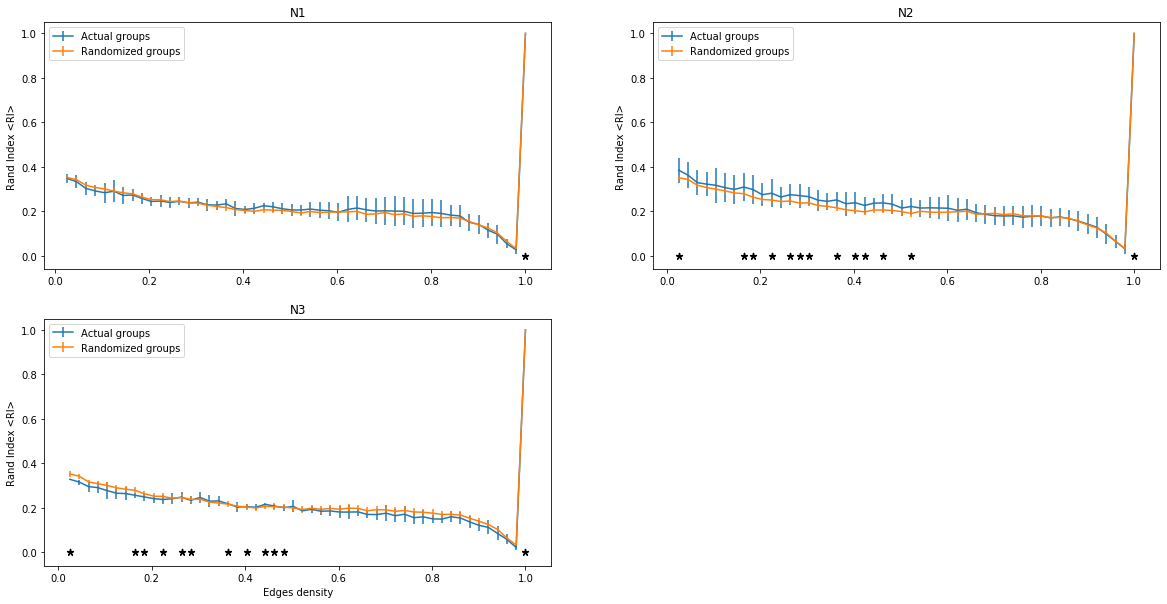

In [12]:
plt.figure(figsize=(20,10))

# Actual groups
n1ag_means = []
n2ag_means = []
n3ag_means = []
n1ag_stds = []
n2ag_stds = []
n3ag_stds = []

n1rg_means = []
n2rg_means = []
n3rg_means = []
n1rg_stds = []
n2rg_stds = []
n3rg_stds = []

n1_pvalues = []
n2_pvalues = []
n3_pvalues = []

for i, density in enumerate(densities):
    
    print("density " + str(i) + ": " + str(density))
    
    modulesByStage = buildModules(i, graphsBySleepStage)    
    rands = rand_value(modulesByStage)
    
    n1ag_means.append(rands[nxStages[0]][0])
    n2ag_means.append(rands[nxStages[1]][0])
    n3ag_means.append(rands[nxStages[2]][0])
    n1ag_stds.append(rands[nxStages[0]][1])
    n2ag_stds.append(rands[nxStages[1]][1])
    n3ag_stds.append(rands[nxStages[2]][1])
    
    distn1, distn2, distn3 = calculateEmpiricDistribution(modulesByStage)

    n1_pvalues.append(calculate_pvalue(distn1, n1ag_means[i]))
    n2_pvalues.append(calculate_pvalue(distn2, n2ag_means[i]))
    n3_pvalues.append(calculate_pvalue(distn3, n2ag_means[i]))

    mean, std = calculate_mean_std_dist(distn1)
    n1rg_means.append(mean)
    n1rg_stds.append(std)

    mean, std = calculate_mean_std_dist(distn2)
    n2rg_means.append(mean)
    n2rg_stds.append(std)
    
    mean, std = calculate_mean_std_dist(distn3)
    n3rg_means.append(mean)
    n3rg_stds.append(std)    

plt.subplot(2,2,1)
plt.errorbar(densities, n1ag_means, n1ag_stds, label = "Actual groups")
plt.errorbar(densities, n1rg_means, n1rg_stds, label = "Randomized groups")
significance_x, significance_y = createSignificanceAxes(densities, n1_pvalues)
plt.scatter(significance_x, significance_y, c='black', marker=(5, 2))
plt.title(nxStages[0])
plt.legend()
plt.ylabel('Rand Index <RI>');

plt.subplot(2,2,2)
plt.errorbar(densities, n2ag_means, n2ag_stds, label = "Actual groups")
plt.errorbar(densities, n2rg_means, n2rg_stds, label = "Randomized groups")
significance_x, significance_y = createSignificanceAxes(densities, n2_pvalues)
plt.scatter(significance_x, significance_y, c='black', marker=(5, 2))
plt.title(nxStages[1])
plt.legend()
plt.ylabel('Rand Index <RI>');

plt.subplot(2,2,3)
plt.errorbar(densities, n3ag_means, n3ag_stds, label = "Actual groups")
plt.errorbar(densities, n3rg_means, n3rg_stds, label = "Randomized groups")
significance_x, significance_y = createSignificanceAxes(densities, n3_pvalues)
plt.scatter(significance_x, significance_y, c='black', marker=(5, 2))
plt.xlabel('Edges density')
plt.title(nxStages[2])
plt.legend()
plt.ylabel('Rand Index <RI>');

In [13]:
n1_pvalues

[0.615,
 0.708,
 0.877,
 0.862,
 0.86,
 0.496,
 0.774,
 0.631,
 0.617,
 0.707,
 0.643,
 0.61,
 0.514,
 0.475,
 0.364,
 0.429,
 0.32,
 0.151,
 0.37,
 0.392,
 0.199,
 0.152,
 0.198,
 0.335,
 0.328,
 0.23,
 0.285,
 0.29,
 0.369,
 0.512,
 0.285,
 0.238,
 0.161,
 0.255,
 0.365,
 0.23,
 0.28,
 0.258,
 0.28,
 0.197,
 0.166,
 0.286,
 0.297,
 0.557,
 0.408,
 0.725,
 0.627,
 0.858,
 0.809,
 0.0]

In [14]:
n2_pvalues

[0.013,
 0.093,
 0.186,
 0.141,
 0.156,
 0.168,
 0.151,
 0.035,
 0.023,
 0.077,
 0.027,
 0.114,
 0.047,
 0.031,
 0.049,
 0.106,
 0.059,
 0.024,
 0.057,
 0.027,
 0.033,
 0.051,
 0.045,
 0.057,
 0.174,
 0.045,
 0.23,
 0.166,
 0.155,
 0.196,
 0.372,
 0.326,
 0.355,
 0.531,
 0.663,
 0.579,
 0.663,
 0.592,
 0.515,
 0.494,
 0.491,
 0.456,
 0.502,
 0.451,
 0.422,
 0.394,
 0.621,
 0.504,
 0.524,
 0.0]

In [15]:
n3_pvalues

[0.013,
 0.071,
 0.16,
 0.165,
 0.153,
 0.156,
 0.164,
 0.028,
 0.023,
 0.08,
 0.037,
 0.096,
 0.048,
 0.038,
 0.05,
 0.085,
 0.066,
 0.026,
 0.058,
 0.036,
 0.05,
 0.046,
 0.034,
 0.048,
 0.193,
 0.062,
 0.207,
 0.128,
 0.196,
 0.184,
 0.387,
 0.276,
 0.341,
 0.579,
 0.675,
 0.579,
 0.64,
 0.633,
 0.528,
 0.438,
 0.496,
 0.404,
 0.479,
 0.43,
 0.415,
 0.411,
 0.652,
 0.453,
 0.551,
 0.0]

In [18]:
randBinList(len(subjects))

[1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1]

In [20]:
randBinList(len(subjects))

[0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1]

In [21]:
randBinList(len(subjects))

[1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1]